# 1. 강의영상 

In [1]:
#{{<video https://youtu.be/playlist?list=PLQqh36zP38-wTzMRmZzvr2TL12DNo6jXF&si=RnG6_-uhn9Yb57nU >}}

# 2. Imports

In [2]:
import torch 
import torchvision
import fastai.vision.all
import matplotlib.pyplot as plt
import requests

# 3. XAI란?

<https://brunch.co.kr/@hvnpoet/140>

# 4. CAM의 구현을 위한 예비학습

## A. Data

In [3]:
path = fastai.data.external.untar_data(fastai.data.external.URLs.PETS)/'images'

In [4]:
path.ls()

(#7393) [Path('/home/cgb3/.fastai/data/oxford-iiit-pet/images/boxer_177.jpg'),Path('/home/cgb3/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_131.jpg'),Path('/home/cgb3/.fastai/data/oxford-iiit-pet/images/keeshond_165.jpg'),Path('/home/cgb3/.fastai/data/oxford-iiit-pet/images/samoyed_80.jpg'),Path('/home/cgb3/.fastai/data/oxford-iiit-pet/images/Siamese_224.jpg'),Path('/home/cgb3/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_59.jpg'),Path('/home/cgb3/.fastai/data/oxford-iiit-pet/images/saint_bernard_159.jpg'),Path('/home/cgb3/.fastai/data/oxford-iiit-pet/images/american_bulldog_143.jpg'),Path('/home/cgb3/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_142.jpg'),Path('/home/cgb3/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_78.jpg')...]

In [5]:
fnames = fastai.data.transforms.get_image_files(path)
def label_func(fname):
    if fname[0].isupper():
        return 'cat'
    else:
        return 'dog'
dls = fastai.vision.data.ImageDataLoaders.from_name_func(
    path = path,
    fnames = fnames,
    label_func = label_func,
    item_tfms = fastai.vision.augment.Resize(512)
) 

## B. 이미지 자료 불러오기

`-` 원래 우리가 아는 방법: path 를 의미하는 string $\to$ torch.tensor

In [7]:
x = torchvision.io.read_image('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_106.jpg')
print(f'type(불테리어): {type(x)}')
print(f'shape(불테리어): {x.shape}')
print(f'dtype(불테리어): {x.dtype}')

type(불테리어): <class 'torch.Tensor'>
shape(불테리어): torch.Size([3, 500, 333])
dtype(불테리어): torch.uint8


`-` fastai를 이용하는 방법: path/주소 를 의미하는 string $\to$ PILImage $\to$ fastai.torch_core.TensorImage $\to$ torch.tensor

In [8]:
x_pil = fastai.vision.core.PILImage.create('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_106.jpg')
x = next(iter(dls.test_dl([x_pil])))[0]
print(f'type(불테리어): {type(x)}')
print(f'shape(불테리어): {x.shape}')
print(f'dtype(불테리어): {x.dtype}')
# print('---')
# x = torch.tensor(x)
# print(f'type(불테리어): {type(x)}')
# print(f'shape(불테리어): {x.shape}')
# print(f'dtype(불테리어): {x.dtype}')

type(불테리어): <class 'fastai.torch_core.TensorImage'>
shape(불테리어): torch.Size([1, 3, 512, 512])
dtype(불테리어): torch.float32


In [9]:
x_pil = fastai.vision.core.PILImage.create(requests.get('https://github.com/guebin/DL2024/blob/main/imgs/01wk-hani1.jpeg?raw=true').content)
x = next(iter(dls.test_dl([x_pil])))[0]
print(f'type(하니): {type(x)}')
print(f'shape(하니): {x.shape}')
print(f'dtype(하니): {x.dtype}')

type(하니): <class 'fastai.torch_core.TensorImage'>
shape(하니): torch.Size([1, 3, 512, 512])
dtype(하니): torch.float32


`-` 참고로 아래와 같이 불러올 수도 있음 (이 강의에서 활용X)

In [10]:
x_pil = fastai.vision.core.PILImage.create('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_106.jpg')
x = fastai.torch_core.TensorImage(x_pil)
print(f'type(불테리어): {type(x)}')
print(f'shape(불테리어): {x.shape}')
print(f'dtype(불테리어): {x.dtype}')

type(불테리어): <class 'fastai.torch_core.TensorImage'>
shape(불테리어): torch.Size([500, 333, 3])
dtype(불테리어): torch.uint8


In [11]:
x_pil = fastai.vision.core.PILImage.create(requests.get('https://github.com/guebin/DL2024/blob/main/imgs/01wk-hani1.jpeg?raw=true').content)
x = fastai.torch_core.TensorImage(x_pil)
print(f'type(하니): {type(x)}')
print(f'shape(하니): {x.shape}')
print(f'dtype(하니): {x.dtype}')

type(하니): <class 'fastai.torch_core.TensorImage'>
shape(하니): torch.Size([1009, 757, 3])
dtype(하니): torch.uint8


## C. 이미지 자료 시각화 

In [12]:
x_pil = fastai.vision.core.PILImage.create(requests.get('https://github.com/guebin/DL2024/blob/main/imgs/01wk-hani1.jpeg?raw=true').content)
x = next(iter(dls.test_dl([x_pil])))[0]
x.shape

torch.Size([1, 3, 512, 512])

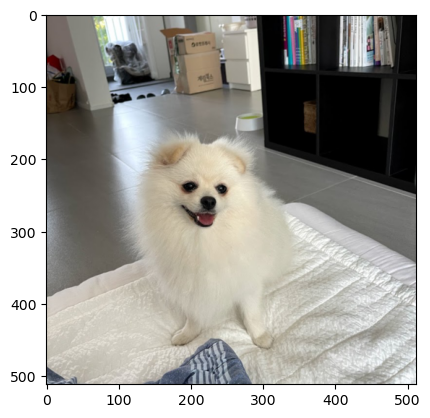

In [13]:
plt.imshow(torch.einsum('ocij->ijc',x).to("cpu"))

## D. AP layer 

In [14]:
ap = torch.nn.AdaptiveAvgPool2d(output_size=1) 

In [15]:
X = torch.arange(1*3*4*4).reshape(1,3,4,4)*1.0 
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[16., 17., 18., 19.],
          [20., 21., 22., 23.],
          [24., 25., 26., 27.],
          [28., 29., 30., 31.]],

         [[32., 33., 34., 35.],
          [36., 37., 38., 39.],
          [40., 41., 42., 43.],
          [44., 45., 46., 47.]]]])

In [16]:
ap(X) # 채널별로 평균구해줌..

tensor([[[[ 7.5000]],

         [[23.5000]],

         [[39.5000]]]])

In [17]:
r,g,b = X[0,...]
r.mean(),g.mean(),b.mean()

(tensor(7.5000), tensor(23.5000), tensor(39.5000))

In [18]:
ap(r),ap(g),ap(b)

(tensor([[7.5000]]), tensor([[23.5000]]), tensor([[39.5000]]))

## E. AP, Linear의 교환

`-` 신기한 거 보여줄까요? 

In [19]:
ap(r*0.1 + g*0.2 + b*0.3)

tensor([[17.3000]])

In [20]:
ap(r)*0.1 + ap(g)*0.2 + ap(b)*0.3 

tensor([[17.3000]])

- 별로 안 신기함. 당연한 것 아니야?

`-` torch.nn.Linear() 와 torch.nn.Faltten()을 이용한 구현 

In [21]:
l = torch.nn.Linear(in_features=3,out_features=1,bias=False)
l.weight.data = torch.tensor([[ 0.1, 0.2, 0.3]])

In [22]:
X.shape, l.weight.data.shape

(torch.Size([1, 3, 4, 4]), torch.Size([1, 3]))

In [23]:
flatten = torch.nn.Flatten()
print(f'방법1: ap -> flatten -> linear: {l(flatten(ap(X)))}')
print(f'방법2: linear -> ap -> flatten: {flatten(ap(torch.einsum('ocij, kc -> okij',X,l.weight)))}')

방법1: ap -> flatten -> linear: tensor([[17.3000]], grad_fn=<MmBackward0>)
방법2: linear -> ap -> flatten: tensor([[17.3000]], grad_fn=<ViewBackward0>)


`-` 차원살펴보기 

In [24]:
print('방법1')
print(f'{X.shape}  -- X')
print(f'{ap(X).shape}  -- ap(X)')
print(f'{flatten(ap(X)).shape}  -- flatten(ap(X))')
print(f'{l(flatten(ap(X))).shape}  -- l(flatten(ap(X)))')

방법1
torch.Size([1, 3, 4, 4])  -- X
torch.Size([1, 3, 1, 1])  -- ap(X)
torch.Size([1, 3])  -- flatten(ap(X))
torch.Size([1, 1])  -- l(flatten(ap(X)))


In [25]:
print('방법2')
print(f'{X.shape}  -- X')
print(f'{torch.einsum('ocij, kc -> okij',X,l.weight).shape}  -- l(X)')
print(f'{ap(torch.einsum('ocij, kc -> okij',X,l.weight)).shape}  -- ap(l(X))')
print(f'{flatten(ap(torch.einsum('ocij, kc -> okij',X,l.weight))).shape}  -- flatten(ap(l(X)))')

방법2
torch.Size([1, 3, 4, 4])  -- X
torch.Size([1, 1, 4, 4])  -- l(X)
torch.Size([1, 1, 1, 1])  -- ap(l(X))
torch.Size([1, 1])  -- flatten(ap(l(X)))


`-` 정리

$$\underset{(1,3,4,4)}{\boldsymbol X} \overset{ap}{\to} \underset{(1,3,1,1)}{{\boldsymbol \sharp}}\overset{flatten}{\to} \underset{(1,3)}{{\boldsymbol \sharp}}\overset{linear}{\to} \underset{(1,1)}{\hat{\boldsymbol y}} = [[17.3]]$$

$$\underset{(1,3,4,4)}{\boldsymbol X} \overset{linear}{\to} \underset{(1,1,4,4)}{{\boldsymbol \sharp}}\overset{ap}{\to} \underset{(1,1,1,1)}{{\boldsymbol \sharp}}\overset{flatten}{\to} \underset{(1,1)}{\hat{\boldsymbol y}} = [[17.3]]$$

# 5. CAM의 구현

## A. 1단계 -- 이미지분류 잘하는 네트워크 선택 

In [6]:
lrnr = fastai.vision.learner.vision_learner(
    dls = dls,
    arch = fastai.vision.models.resnet34,
    metrics = [fastai.metrics.accuracy]
) 

In [7]:
lrnr.fine_tune(1)

## B. 2단계-- 네트워크의 끝 부분 수정 

`-` 모형의 분해 

In [8]:
net1= lrnr.model[0]
net2= lrnr.model[1]

`-` net2를 좀더 살펴보자. 

In [9]:
net2

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [10]:
_X, _y = dls.one_batch() 

In [11]:
net1.to("cpu")
net2.to("cpu") 
_X = _X.to("cpu")

In [12]:
print(net1(_X).shape)
print(net2[0](net1(_X)).shape)
print(net2[1](net2[0](net1(_X))).shape)
print(net2[2](net2[1](net2[0](net1(_X)))).shape)

torch.Size([64, 512, 16, 16])
torch.Size([64, 1024, 1, 1])
torch.Size([64, 1024])
torch.Size([64, 1024])


`-` net2를 아래와 같이 수정하고 재학습하자 (왜?) 

In [13]:
net2= torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), # (64,512,16,16) -> (64,512,1,1) 
    torch.nn.Flatten(), # (64,512,1,1) -> (64,512) 
    torch.nn.Linear(512,2,bias=False) # (64,512) -> (64,2) 
)

In [14]:
net = torch.nn.Sequential(
    net1,
    net2
)

In [15]:
lrnr2 = fastai.learner.Learner(dls,net,metrics=[fastai.metrics.accuracy])

In [16]:
lrnr2.loss_func, lrnr.loss_func ## 알아서 기존의 loss function으로 잘 들어가 있음. 

(FlattenedLoss of CrossEntropyLoss(), FlattenedLoss of CrossEntropyLoss())

In [17]:
lrnr2.fine_tune(5) # net2를 수정해서 accuracy가 안좋아지긴 했는데 그래도 쓸만함 

## C. 3단계-- 수정된 net2에서 Linear와 AP의 순서를 바꿈 

`-` 1개의 observation을 고정하였을 경우 출력과정 상상 

In [20]:
x_pil = fastai.vision.core.PILImage.create('/home/cgb3/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_106.jpg')
x = next(iter(dls.test_dl([x_pil])))[0]

In [21]:
print(net1(x).shape)
print(net2[0](net1(x)).shape)
print(net2[1](net2[0](net1(x))).shape)
print(net2[2](net2[1](net2[0](net1(x)))).shape)

torch.Size([1, 512, 16, 16])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512])
torch.Size([1, 2])


`-` 최종결과 확인 

In [22]:
net(x)

TensorImage([[-6.4995,  6.9970]], device='cuda:0', grad_fn=<AliasBackward0>)

In [23]:
dls.vocab

['cat', 'dog']

- net(x)에서 뒤쪽의 값이 클수록 'dog'를 의미한다. 

`-` net2의 순서 바꾸기 전 전체 네트워크: 

$$\underset{(1,3,512,512)}{\boldsymbol x} \overset{net_1}{\to} \left( \underset{(1,512,16,16)}{\tilde{\boldsymbol x}} \overset{ap}{\to} \underset{(1,512,1,1)}{{\boldsymbol \sharp}}\overset{flatten}{\to} \underset{(1,512)}{{\boldsymbol \sharp}}\overset{linear}{\to} \underset{(1,2)}{\hat{\boldsymbol y}}\right) = [-9.0358,  9.0926]$$

`-` 아래와 같이 순서를 바꿔서 한번 계산해보고 싶다. (왜???..)

$$\underset{(1,3,224,224)}{\boldsymbol x} \overset{net_1}{\to} \left( \underset{(1,512,16,16)}{\tilde{\boldsymbol x}} \overset{linear}{\to} \underset{(1,2,16,16)}{{\bf why}}\overset{ap}{\to} \underset{(1,2,1,1)}{{\boldsymbol \sharp}}\overset{flatten}{\to} \underset{(1,2)}{\hat{\boldsymbol y}}\right) = [−9.0358,9.0926]$$

- 여기에서 (1,512,16,16) -> (1,2,16,16) 로 가는 선형변환을 적용하는 방법? **(16,16) each pixel에 대하여 (512 $\to$ 2)로 가는 변환을 수행**

`-` 통찰: 이 경우 특이하게도 레이어의 순서를 바꿨을때 출력이 동일함 (선형변환하고 평균내거나 평균내고 선형변환하는건 같으니까) 

`-` 구현해보자. 

In [25]:
why = torch.einsum('ocij,kc->okij',net1(x),net2[2].weight)

In [26]:
net2[0](why)

TensorImage([[[[-6.4995]],

              [[ 6.9970]]]], device='cuda:0', grad_fn=<AliasBackward0>)

In [27]:
net(x)

TensorImage([[-6.4995,  6.9970]], device='cuda:0', grad_fn=<AliasBackward0>)

### 잠깐 멈추고 생각 좀 해보자..

`-` 이미지

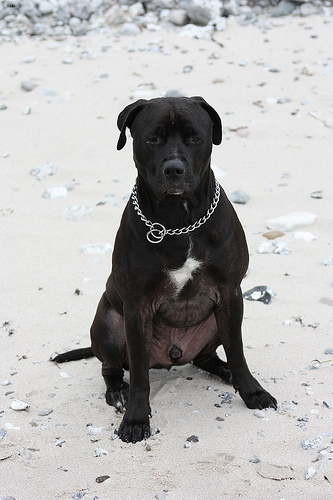

In [29]:
x_pil

`-` 네트워크의 결과

In [30]:
net2(net1(x))

TensorImage([[-6.4995,  6.9970]], device='cuda:0', grad_fn=<AliasBackward0>)

- -9.0358 << 9.0926 이므로 'ximg'는 높은 확률로 개라는 뜻이다. 

`-` 아래의네트워크를 관찰 

$$\underset{(1,2,16,16)}{{\bf why}}\overset{ap}{\to} \underset{(1,2,1,1)}{{\boldsymbol \sharp}}\overset{flatten}{\to} \underset{(1,2)}{\hat{\boldsymbol y}} = [-9.0358,9.0926]$$

In [31]:
net2[0](why)

TensorImage([[[[-6.4995]],

              [[ 6.9970]]]], device='cuda:0', grad_fn=<AliasBackward0>)

더 파고들어서 분석해보자. 

In [32]:
why.shape

torch.Size([1, 2, 16, 16])

In [33]:
(why[0,0,:,:]).mean(), (why[0,1,:,:]).mean()

(TensorImage(-6.4995, device='cuda:0', grad_fn=<AliasBackward0>),
 TensorImage(6.9970, device='cuda:0', grad_fn=<AliasBackward0>))

***`why[0,0,:,:]`***

In [34]:
#collapse_output
(why[0,0,:,:]).to(torch.int64)

TensorImage([[  0,   0,   0,   0,   0,   0,  -4,  -7,  -6,  -4,  -1,   0,   0,
                0,   0,   0],
             [  0,   0,   0,   1,   0,  -5, -16, -25, -25, -16,  -7,  -1,   0,
                0,   0,   0],
             [  0,   0,   1,   1,  -1, -13, -33, -48, -47, -33, -16,  -3,   0,
                0,   0,   0],
             [  0,   1,   1,   1,  -4, -21, -45, -62, -62, -45, -24,  -5,   0,
                1,   1,   0],
             [  0,   0,   0,   0,  -7, -24, -47, -63, -67, -50, -24,  -5,   0,
                1,   0,   0],
             [  0,   0,   0,   0,  -7, -24, -45, -61, -59, -46, -22,  -6,   0,
                1,   0,   0],
             [  0,   1,   1,   1,  -2, -16, -33, -46, -43, -32, -16,  -5,   0,
                0,   0,   0],
             [  0,   1,   1,   1,   0,  -8, -18, -27, -26, -18,  -8,  -3,   0,
                0,   0,   0],
             [  0,   1,   0,   0,   0,  -2,  -5,  -6,  -6,  -6,  -3,  -1,   0,
                0,   0,   0],
             [  0, 

- 이 값들의 평균은 -9.0358 이다. (이 값이 클수록 이 그림이 고양이라는 의미 = 이 값이 작을수록 이 그림이 고양이가 아니라는 의미) 
- 그런데 살펴보니 대부분의 위치에서 0에 가까운 값을 가짐. 다만 특정위치에서 엄청 큰 작은값이 있어서 -9.0358이라는 평균값이 나옴 $\to$ 특정위치에 존재하는 엄청 작은 값들은 ximg가 고양이가 아니라고 판단하는 근거가 된다. 

***`why[0,1,:,:]`***

In [35]:
#collapse_output
(why[0,1,:,:]).to(torch.int64)

TensorImage([[ 0,  1,  0,  0,  0,  1,  5,  8,  7,  5,  2,  0,  0,  0,  0,  0],
             [ 1,  0,  0, -1,  0,  6, 18, 27, 27, 17,  8,  2,  0,  0,  0,  0],
             [ 0,  0, -1, -1,  1, 14, 35, 51, 49, 35, 17,  4,  0,  0,  0,  0],
             [ 0,  0, -1,  0,  5, 22, 47, 66, 66, 47, 25,  6,  0, -1, -1,  0],
             [ 0,  0,  0,  0,  8, 25, 48, 66, 71, 52, 25,  6,  0,  0,  0,  0],
             [ 0,  0,  0,  0,  7, 24, 46, 62, 62, 47, 23,  6,  0,  0,  0,  0],
             [ 0,  0, -1,  0,  3, 16, 34, 47, 44, 32, 16,  5,  0,  0,  0,  0],
             [ 0, -1, -1, -1,  0,  8, 19, 28, 27, 18,  9,  3,  0,  0,  0,  0],
             [ 0, -1,  0,  0,  0,  3,  5,  7,  6,  7,  3,  1,  1,  0,  0,  0],
             [ 0,  0,  1,  5,  6,  2,  0,  0,  0,  2,  2,  2,  2,  2,  1,  0],
             [ 0,  0,  6, 12, 12,  5,  0, -1, -1,  1,  4,  4,  5,  5,  1,  0],
             [ 0,  2,  7, 14, 12,  6,  0, -2, -4, -2,  3,  4,  3,  3,  1,  1],
             [ 1,  4,  7,  9,  8,  4,  0, -4, -8, -6

- 이 값들의 평균은 9.0926 이다. (이 값이 클수록 이 그림이 강아지라는 의미) 
- 그런데 살펴보니 대부분의 위치에서 0에 가까운 값을 가짐. 다만 특정위치에서 엄청 큰 값들이 있어서 9.0926이라는 평균값이 나옴 $\to$ 특정위치에 존재하는 엄청 큰 값들은 결국 ximg를 강아지라고 판단하는 근거가 된다. 

`-` 시각화

In [36]:
why_cat = why[0,0,:,:]
why_dog = why[0,1,:,:]

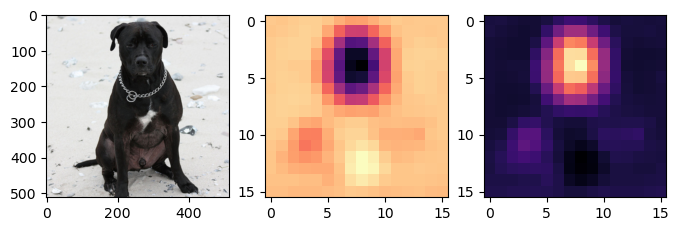

In [37]:
fig, ax = plt.subplots(1,3,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[1].imshow(why_cat.to("cpu").detach(),cmap='magma')
ax[2].imshow(why_dog.to("cpu").detach(),cmap='magma')

- magma = 검은색 < 보라색 < 빨간색 < 노란색
- 왼쪽그림의 검은 부분은 고양이가 아니라는 근거, 오른쪽그림의 노란부분은 강아지라는 근거 

`-` why_cat, why_dog를 (16,16) $\to$ (512,512) 로 resize 

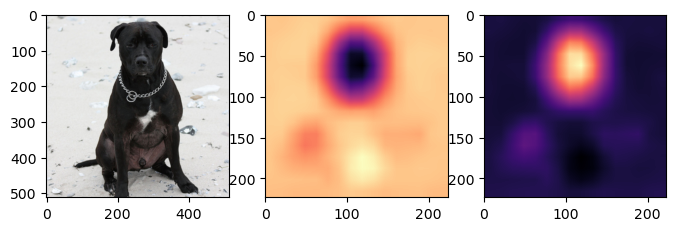

In [38]:
fig, ax = plt.subplots(1,3,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[1].imshow(why_cat.to("cpu").detach(),cmap='magma',extent=(0,223,223,0),interpolation='bilinear')
ax[2].imshow(why_dog.to("cpu").detach(),cmap='magma',extent=(0,223,223,0),interpolation='bilinear')

`-` 겹쳐그리기

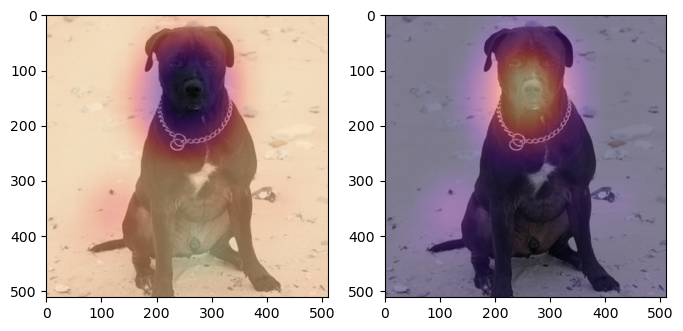

In [40]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[0].imshow(why_cat.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5)
ax[1].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[1].imshow(why_dog.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5)

`-` 하니이미지 시각화

In [41]:
x_pil = fastai.vision.core.PILImage.create(requests.get('https://github.com/guebin/DL2022/blob/main/posts/I.%20Overview/2022-09-06-hani01.jpeg?raw=true').content)
x = next(iter(dls.test_dl([x_pil])))[0]

In [42]:
x.shape

torch.Size([1, 3, 512, 512])

In [43]:
why = torch.einsum('cb,abij->acij',net2[2].weight,net1(x))
why_cat = why[0,0,:,:]
why_dog = why[0,1,:,:]

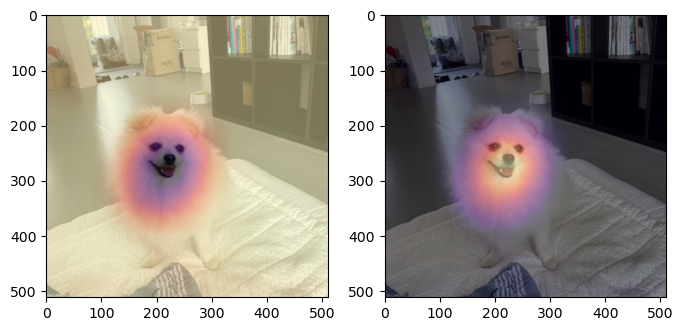

In [45]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[0].imshow(why_cat.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5)
ax[1].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[1].imshow(why_dog.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5)

`-` 하니이미지 시각화 with prob

In [46]:
sftmax=torch.nn.Softmax(dim=1)

In [47]:
sftmax(net(x))

TensorImage([[6.0670e-04, 9.9939e-01]], device='cuda:0',
            grad_fn=<AliasBackward0>)

In [48]:
catprob, dogprob = sftmax(net(x))[0,0].item(), sftmax(net(x))[0,1].item()

Text(0.5, 1.0, 'dogprob=0.999393')

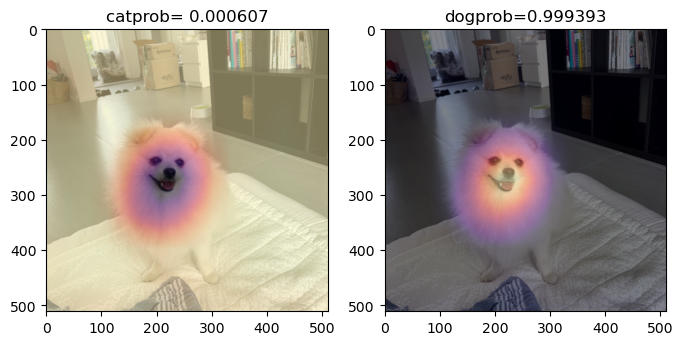

In [50]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[0].imshow(why_cat.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5)
ax[0].set_title(f'catprob= {catprob:.6f}') 
ax[1].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[1].imshow(why_dog.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5)
ax[1].set_title(f'dogprob={dogprob:.6f}')

## D. 4단계 -- CAM 시각화 

In [51]:
sftmax = torch.nn.Softmax(dim=1)

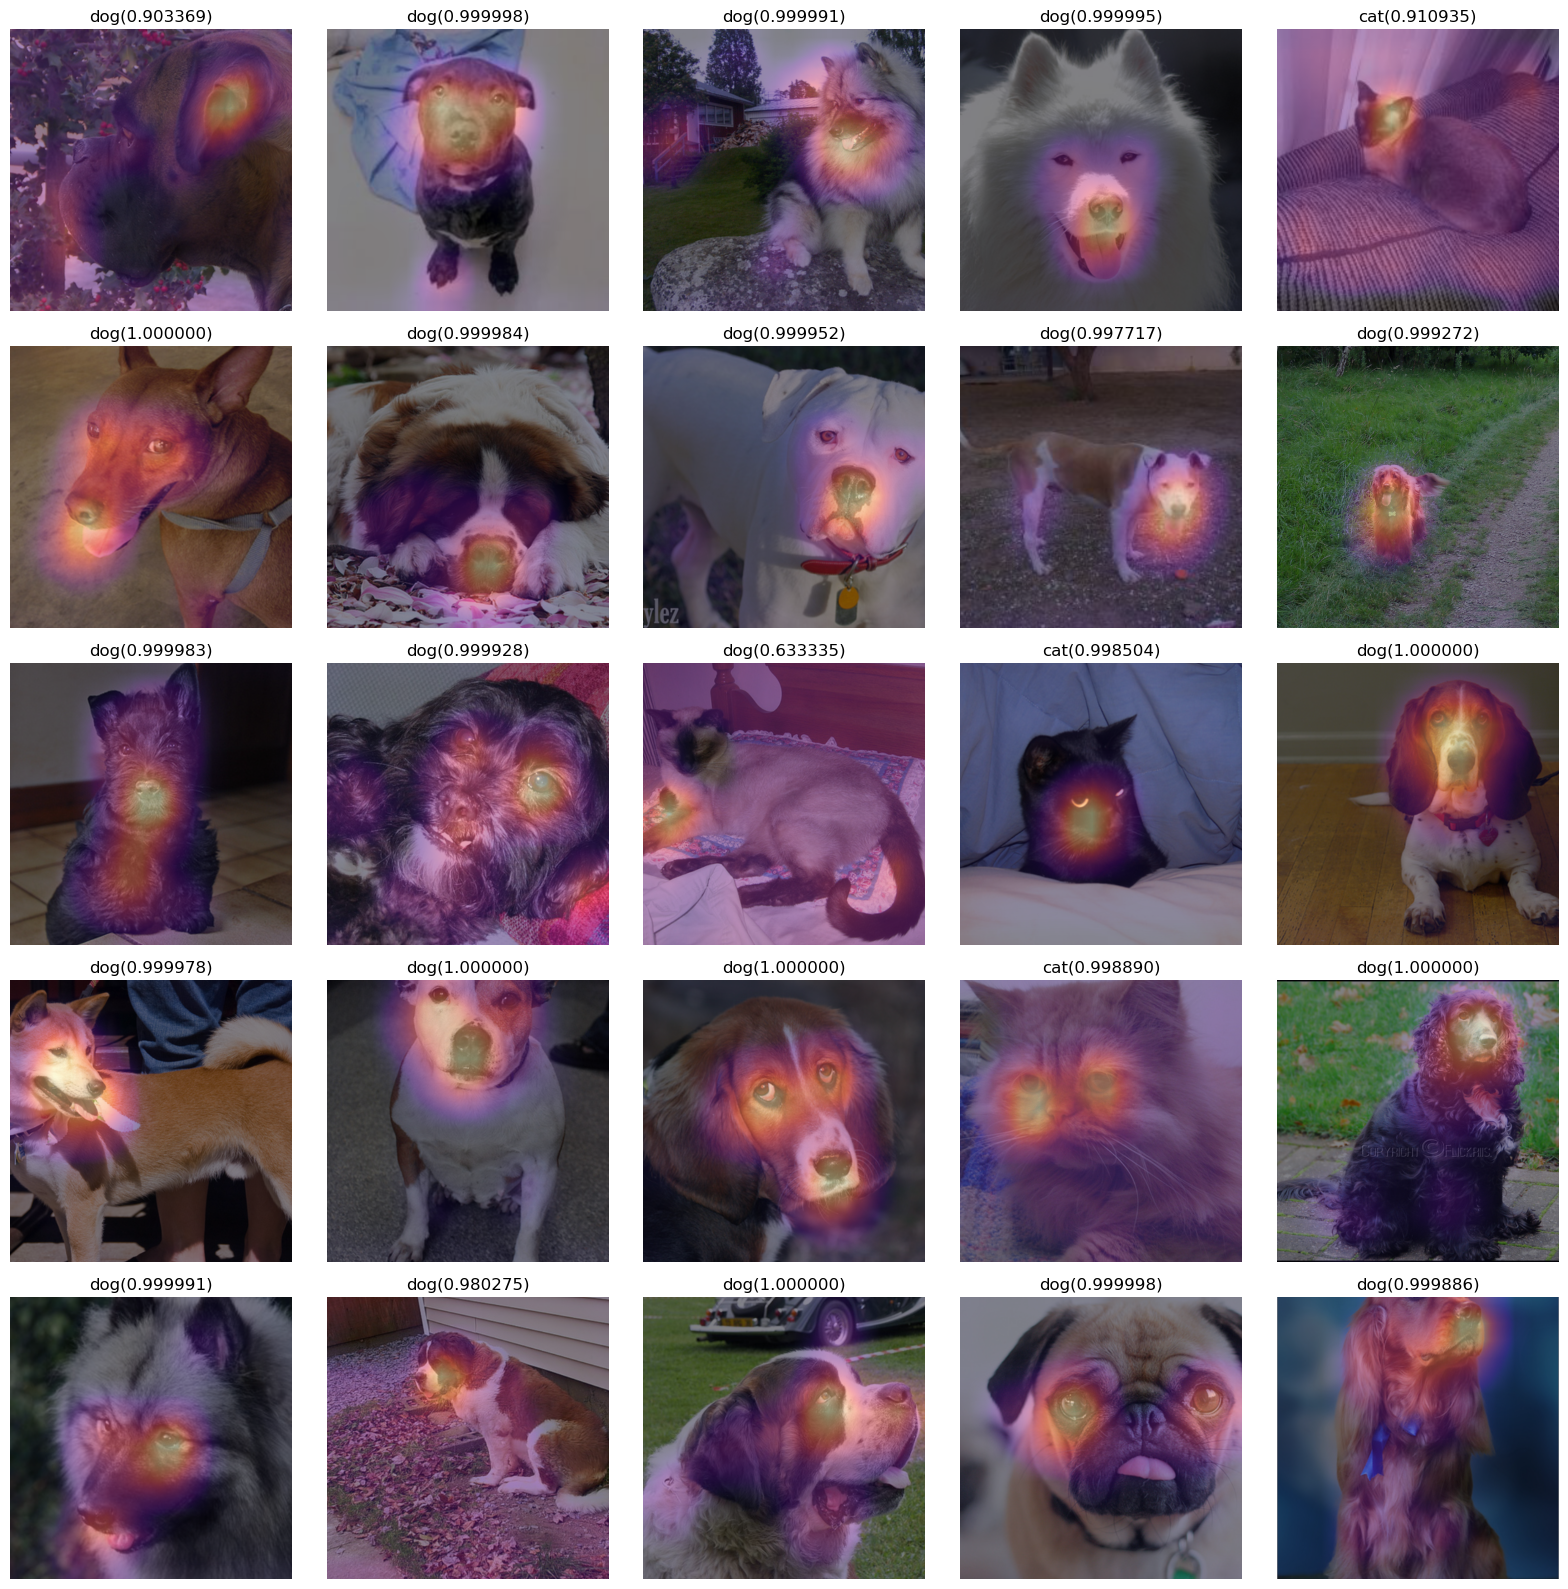

In [52]:
fig, ax = plt.subplots(5,5) 
k=0 
for i in range(5):
    for j in range(5): 
        x, = next(iter(dls.test_dl([fastai.vision.core.PILImage.create(fastai.data.transforms.get_image_files(path)[k])])))
        why = torch.einsum('cb,abij -> acij', net2[2].weight, net1(x))
        why_cat = why[0,0,:,:] 
        why_dog = why[0,1,:,:] 
        catprob, dogprob = sftmax(net(x))[0][0].item(), sftmax(net(x))[0][1].item()
        if catprob>dogprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_cat.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("cat(%2f)" % catprob)
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_dog.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("dog(%2f)" % dogprob)
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(5,5) 
k=25
for i in range(5):
    for j in range(5): 
        x, = next(iter(dls.test_dl([fastai.vision.core.PILImage.create(fastai.data.transforms.get_image_files(path)[k])])))
        why = torch.einsum('cb,abij -> acij', net2[2].weight, net1(x))
        why_cat = why[0,0,:,:] 
        why_dog = why[0,1,:,:] 
        catprob, dogprob = sftmax(net(x))[0][0].item(), sftmax(net(x))[0][1].item()
        if catprob>dogprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_cat.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("cat(%2f)" % catprob)
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_dog.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("dog(%2f)" % dogprob)
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(5,5) 
k=50
for i in range(5):
    for j in range(5): 
        x, = next(iter(dls.test_dl([fastai.vision.core.PILImage.create(fastai.data.transforms.get_image_files(path)[k])])))
        why = torch.einsum('cb,abij -> acij', net2[2].weight, net1(x))
        why_cat = why[0,0,:,:] 
        why_dog = why[0,1,:,:] 
        catprob, dogprob = sftmax(net(x))[0][0].item(), sftmax(net(x))[0][1].item()
        if catprob>dogprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_cat.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("cat(%2f)" % catprob)
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_dog.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("dog(%2f)" % dogprob)
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(5,5) 
k=75
for i in range(5):
    for j in range(5): 
        x, = next(iter(dls.test_dl([fastai.vision.core.PILImage.create(fastai.data.transforms.get_image_files(path)[k])])))
        why = torch.einsum('cb,abij -> acij', net2[2].weight, net1(x))
        why_cat = why[0,0,:,:] 
        why_dog = why[0,1,:,:] 
        catprob, dogprob = sftmax(net(x))[0][0].item(), sftmax(net(x))[0][1].item()
        if catprob>dogprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_cat.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("cat(%2f)" % catprob)
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_dog.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("dog(%2f)" % dogprob)
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()